Loss @ 1999 => 0.004773: 100%|██████████| 2000/2000 [00:47<00:00, 42.18it/s]


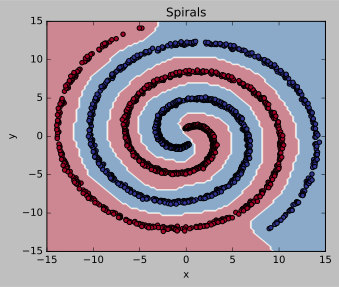

In [ ]:
# Ravindra Bisram 
# ECE-472 Deep Learning HW 2
# Binary Classification on spirals dataset using Multi-layer perceptron. 
"""
On my quest to find an effective perceptron model for spiral classification, I
played with every parameter possible, including number of layers, number of 
neurons per layer, learning_rate, batch_size, the lambda for L2 regularization, 
activation function, and optimization algorithms.
  - Optimization Aglo - SGD performed terribly during testing, and was thus
  replaced by Adam. Once Adam was working I also tried to use Adagrad, but that
  was pretty much as bad as SGD.
  - # Layers - I tested possible configurations of hidden layers ranging from
  a single layer up to 7, but after wild results all around I eventually settled
  on 3 hidden layers and playing with the number of neurons to improve the loss.
  The higher amounts of layers did not provide any improvements so I opted to 
  keep it simpler. 
  - Activation Functions - relu and swish worked pretty much the same for the 
  network I ended up with. They both converged to a loss of around 0.0033. Elu
  could not hang with them. 
  - batch_size - I increased the batch size from 32 to 128 and saw improved 
  results. 
  - learning_rate - the learning rate had to be decreased because the rate of 
  0.1 was causing the loss to oscillate wildly. Lowering it any further actually 
  reduced performace. 
  - Lambda - surprisingly, L2 regularization actually hurt my model (I built 
  around a lambda of zero when it wasn't working), so I had to keep decreasing 
  the lambda parameter until it began improving. Settled on 0.0001
  - For a while, using the sigmoid activation at the last layer of the NN 
  resulted in performance no better than random guessing. Turns out that the
  problem was I was still considering the output to be logits when they were 
  instead probabilities. (logits are the unnomrmalized probabilities)
"""
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf
from tqdm.notebook import tqdm
from tqdm import trange

from dataclasses import dataclass, field, InitVar

random_seed = 31415
num_classes = 2
num_samples = 1000
num_iters = 2000
learning_rate = 0.01
batch_size = 128
LAMBDA = 0.0001 # 0.0001

# learning_rate = 0.01 Lambda = 0.0001 no sigmoid
font = {
    # "family": "Adobe Caslon Pro",
    "size": 10,
}

matplotlib.style.use("classic")
matplotlib.rc("font", **font)

@dataclass
class Data:
  rng: InitVar[np.random.Generator]
  num_classes: int
  num_samples: int
  x: np.ndarray = field(init=False)
  y: np.ndarray = field(init=False)

  def __post_init__(self, rng):
    sigma = 0.1
    self.index = np.arange(self.num_samples * self.num_classes)
    self.x = np.zeros((self.num_samples * self.num_classes, 2), dtype='float32')
    self.y = np.zeros(self.num_samples * self.num_classes, dtype='float32')
   
    """     
    The equation of the spiral of Archimedes is r = aθ, in which a is a
    constant, r is the length of the radius from the centre, or beginning,
    of the spiral, and θ is the angular position (amount of rotation) of the 
    radius.
    # https://matplotlib.org/3.1.1/gallery/misc/fill_spiral.html
    """
    for class_num in range(self.num_classes):
      i = range(self.num_samples * class_num, self.num_samples * (class_num + 1))
      r = np.linspace(1, 15, self.num_samples)
      theta = (np.linspace(class_num * 3, (class_num + 4) * 3, self.num_samples) + np.random.randn(self.num_samples) * sigma)
      self.x[i] = np.c_[r * np.sin(theta), r * np.cos(theta)]
      self.y[i] = class_num

  def get_batch(self, rng, batch_size):
    """Select random subset of examples for training batch for SGD"""
    choices = rng.choice(self.index, size=batch_size)
    return self.x[choices], self.y[choices].flatten()

class Network(tf.Module):

  def __init__(self, sizes, activation=tf.identity):
    '''
    - Sizes - list that contains the number of neurons in the respective layers.
    - activation - the activation function (shout out here to Husam for the 
    inspiration to make the activation a parameter, as well as to default to 
    tf.identity. Much cleaner this way).
    https://adventuresinmachinelearning.com/python-tensorflow-tutorial/
    ''' 
    self.weights = {}
    self.biases = {}
    self.activation = activation
    for i, x, y in zip(range(len(sizes)), sizes[:-1], sizes[1:]):
      layer_w = f"w{i}"
      layer_b = f"b{i}"
      # Initializing the weights and biases in this way improved performance. 
      self.weights[layer_w] = tf.Variable(0.2*tf.random.normal((x, y)), name=layer_w)
      self.biases[layer_w] = tf.Variable(0.001*tf.ones(y), name=layer_b)

  def __call__(self, x):
    for weight in self.weights:
      if weight == "w0":
          self.y_hat = x @ self.weights[weight] + self.biases[weight]
      else:
          self.y_hat = self.activation(self.y_hat) @ self.weights[weight] + self.biases[weight]

    return tf.nn.sigmoid(tf.squeeze(self.y_hat))

def main():
  seed_sequence = np.random.SeedSequence(random_seed)
  np_seed, tf_seed = seed_sequence.spawn(2)
  np_rng = np.random.default_rng(np_seed)
  tf_rng = tf.random.Generator.from_seed(tf_seed.entropy)

  data = Data(
    np_rng,
    num_classes,
    num_samples
  )

  #net = Network([2, 32, 40, 8, 1], tf.nn.relu)
  net = Network([2, 42, 40, 38, 1], tf.nn.relu)
  #net = Network([2, 100, 50,1], tf.nn.relu)

  optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
  bar = trange(num_iters)

  for i in bar:
    with tf.GradientTape() as tape:
      x, y = data.get_batch(np_rng, batch_size)
      y_hat = tf.squeeze(net(x))
      bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
      loss = bce(y, y_hat) 

      # L2 Regularization to penalize large weights
      # https://towardsdatascience.com/how-to-improve-a-neural-network-with-regularization-8a18ecda9fe3
      L2 = 0
      for weight in net.weights:
          L2 += tf.nn.l2_loss(net.weights[weight])
      loss = tf.reduce_mean(loss + LAMBDA * L2) + 1e-15
      
    grads = tape.gradient(loss, net.variables)
    optimizer.apply_gradients(zip(grads, net.variables))

    bar.set_description(f"Loss @ {i} => {loss.numpy():0.6f}")
    bar.refresh()

  
  n = 100
  x = np.linspace(-15, 15, n, dtype='float32')
  y = np.linspace(-15, 15, n, dtype='float32')
  xx, yy, = np.meshgrid(x, y)

  decision = np.zeros((n, n))
  for i in range(n):
      for j in range(n):
          xy = np.reshape([x[j], y[i]], (1, 2))
          p = net(xy)
          if p >= .5:
              decision[i, j] = 1
  
  # Color map info + colors
  # https://matplotlib.org/stable/tutorials/colors/colormaps.html
  #cm = plt.cm.Spectral
  cm = plt.cm.RdYlBu
  cm2 = plt.cm.RdBu
  fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)

  # Office hours tip, use countour f to show the decision bounds 
  plt.contourf(xx, yy, decision, cmap=cm2, alpha=.5)
  plt.scatter(data.x[:, 0], data.x[:, 1], c=data.y, cmap=cm,
              alpha=1, edgecolors='black')

  ax = plt.gca()
  ax.set_title("Spirals")
  ax.set_xlabel("x")
  ax.set_ylabel("y")

  plt.show()

main()